In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn

from incendio.core import BaseModel

In [ ]:
class Model(BaseModel):
    
    def __init__(self):
        super().__init__()
        self.pad = nn.ReflectionPad2d(2)
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.adapt = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.conv1(self.pad(x))
        x = F.leaky_relu(x)
        x = self.conv2(self.pad(x))
        x = F.leaky_relu(x)
        x = self.adapt(x)
        x = self.fc(x.squeeze())
        return torch.sigmoid(x)
    
    
class Model2(BaseModel):

    def __init__(self, c_in, c_outs):
        super().__init__()
        dims = [c_in] + c_outs
        self.enc = nn.Sequential(*[nn.Sequential(nn.ReflectionPad2d(2),
                                   nn.Conv2d(*(c_in, c_out), kernel_size=5),
                                   nn.LeakyReLU())
                                   for c_in, c_out in zip(dims, dims[1:])])
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(c_outs[-1], 1)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.pool(x)
        print(x.shape)
        x = x.squeeze()
        print(x.shape)
        return torch.sigmoid(self.fc(x))

In [ ]:
m2 = Model2(3, [8, 16, 32])
m2

Model2(
  (enc): Sequential(
    (0): Sequential(
      (0): ReflectionPad2d((2, 2, 2, 2))
      (1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): ReflectionPad2d((2, 2, 2, 2))
      (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): ReflectionPad2d((2, 2, 2, 2))
      (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
m1 = Model()
m1

Model(
  (pad): ReflectionPad2d((2, 2, 2, 2))
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (adapt): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
x = torch.randint(255, (2, 3, 4, 4)).float()
x

tensor([[[[  6., 210., 214.,  38.],
          [176., 197.,  80., 112.],
          [168.,  81., 106., 252.],
          [202.,  38., 147., 102.]],

         [[ 28.,  64., 112., 143.],
          [152.,  87., 219., 151.],
          [123., 154.,  79.,  27.],
          [127., 198., 100., 223.]],

         [[253., 150., 155., 243.],
          [222.,  96., 219.,  40.],
          [ 75., 251., 234., 149.],
          [112., 234., 204.,  13.]]],


        [[[248., 236., 113., 144.],
          [223.,  34., 192., 156.],
          [248., 183.,  35.,  35.],
          [101.,  64.,  25., 203.]],

         [[ 23., 145.,  52., 237.],
          [119., 254., 116., 180.],
          [ 70., 199., 149.,   5.],
          [ 78.,  58.,  22.,  34.]],

         [[221., 226.,  48., 109.],
          [212., 146.,  67.,   0.],
          [ 65.,  45., 175.,  85.],
          [233., 187., 190.,  22.]]]])

In [ ]:
x[0].shape

torch.Size([3, 4, 4])

In [ ]:
def show_img(img):
    plt.imshow(img.permute(1, 2, 0) / 255)
    plt.show()

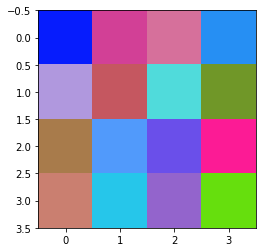

In [ ]:
show_img(x[0])

In [ ]:
x[0].shape

torch.Size([3, 4, 4])

In [ ]:
x.shape

torch.Size([2, 3, 4, 4])

In [ ]:
pad = nn.ReflectionPad2d(2)
x_pad = pad(x)
x_pad.shape

torch.Size([2, 3, 8, 8])

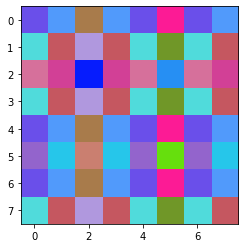

In [ ]:
show_img(x_pad[0])

In [ ]:
class ReflectionPaddedConv2d(nn.Module):
    
    def __init__(self, in_channels, out_channels, padding=1, 
                 kernel_size=3, stride=1, bias=True, **kwargs):
        super().__init__()
        self.reflect = nn.ReflectionPad2d(padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride, padding=0, bias=bias)
    
    def forward(self, x):
        x = self.reflect(x)
        return self.conv(x)

In [ ]:
rc = ReflectionPaddedConv2d(in_channels=3, out_channels=3)
nn.init.constant_(rc.conv.weight, 1)
nn.init.constant_(rc.conv.bias, 0)

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

In [ ]:
r = nn.Conv2d(3, 3, kernel_size=3, padding=1, padding_mode='zeros', bias=True)
nn.init.constant_(r.weight, 1)
nn.init.constant_(r.bias, 0)
x_p = r(x)
x_p.shape

torch.Size([2, 3, 4, 4])

In [ ]:
print(nn.Conv2d.__doc__)

Applies a 2D convolution over an input signal composed of several input
    planes.

    In the simplest case, the output value of the layer with input size
    :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
    can be precisely described as:

    .. math::
        \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


    where :math:`\star` is the valid 2D `cross-correlation`_ operator,
    :math:`N` is a batch size, :math:`C` denotes a number of channels,
    :math:`H` is a height of input planes in pixels, and :math:`W` is
    width in pixels.

    * :attr:`stride` controls the stride for the cross-correlation, a single
      number or a tuple.

    * :attr:`padding` controls the amount of implicit zero-paddings on both
      sides for :attr:`padding` number of points for each dimension.

    * :attr:`dilation